#Facial Keypoint Detection Using CNNs

**The objective of this project is to predict keypoint positions on face images. This can be used as a building block in several applications, such as:**

* tracking faces in images and video
* analysing facial expressions
* detecting dysmorphic facial signs for medical diagnosis
* biometrics / face recognition

# Importing Required Libraries

* matplotlib - Used for plotting. Sometimes can also be used for displaying                  images.
* Pandas     - For loading data and preprocessing the data.
* Numpy      - Used for utilities related to numerical computations.
* tensorflow - Framework for building deep learning networks.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import (
    Flatten,
    Dense,
    Dropout,
    Conv2D,
    LeakyReLU,
    BatchNormalization,
    MaxPool2D,
)

#Importing Data from Kaggle

In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'facial-keypoints-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3486%2F31310%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240330%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240330T081146Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1eaa773592c2c33b51c69e860184768c4f01498a9335e130b897f2b71bb97a3a6a5fd3e3ddb0d09bac800e4c0978f5b26ce02339ed17d8fb2744bfb4248272e3f64e4c78e9f767dd2ee0ec859dbd9e788b3e10dc17f409f55dcfd7ac99edec1e33aa588126d5ab09c5526404740a8dad55f42ef0f2e2532e627b93c4209075afc44bc0bde5ca319b7e4812eda493efa1c462fb9e13a960095e42baf98011b50fd8cd00c93643367c26be915b58133c655eaddf847a1d5ade36eb625c56147b34f9878805f638212e8ed2f547047687e78ed297392c0a9d3abd85e90ab1cae738acf60a2db5b70bf07014b5a8c06ac425f4e8bbd31f526c7ed01b2d28ec8d7909'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 79999502 bytes downloaded
Downloaded and uncompressed: facial-keypoints-detection
Data source import complete.


#Reading Data

In [ ]:
# unzipping the zip file containing the training data
!unzip "/kaggle/input/facial-keypoints-detection/training.zip"

Archive:  /kaggle/input/facial-keypoints-detection/training.zip
  inflating: training.csv            


In [ ]:
# unzipping the zip file containing the testing data
!unzip "/kaggle/input/facial-keypoints-detection/test.zip"

Archive:  /kaggle/input/facial-keypoints-detection/test.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                


In [ ]:
# Loaind the train and test CSVs as dataframes
train_df=pd.read_csv('/content/training.csv')
test_df=pd.read_csv('/content/test.csv')

#Data Exploration

In [ ]:
# Looking at first 5 records of train data
train_df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


The last column in the data is the input image. The image which should be in the form of 2X2 grid has been flattened and provided as a string. The string contains the flattened pixel values seperated by a space. The size of the original image before flattening was 96X96. Hence, each string will have 9216 numerical values each representing a pixel.

In [ ]:
print(f"DataType of the values in the Image column: {type(train_df.iloc[0]['Image'])}")
print(f"Total number of pixels in a image: {len(train_df.iloc[0]['Image'].split())}")

DataType of the values in the Image column: <class 'str'>
Total number of pixels in a image: 9216


In [ ]:
train_df.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,7039.000000,7039.000000,7036.000000,7036.000000,2271.000000,2271.000000,2267.000000,2267.000000,2268.000000,2268.000000,...,7049.000000,7049.000000,2269.000000,2269.000000,2270.000000,2270.000000,2275.000000,2275.000000,7016.000000,7016.000000
mean,66.359021,37.651234,30.306102,37.976943,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,...,48.374186,62.715884,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,48.569472,78.970146
std,3.448233,3.152926,3.083230,3.033621,2.690354,2.307332,3.405852,2.881438,2.350268,2.311907,...,4.280038,5.720567,4.079063,4.579724,3.964552,4.417814,3.323060,5.222500,4.269961,5.407844
min,22.763345,1.616512,0.686592,4.091264,19.064954,27.190098,27.571879,26.250023,5.751046,26.250023,...,12.944699,17.932414,22.923362,57.023258,2.245766,56.690208,12.605173,56.719043,12.536477,25.850503
25%,65.082895,35.900451,28.783339,36.327681,58.039339,36.626283,71.716503,36.085523,35.506126,36.766783,...,46.602370,59.292697,61.257143,72.875707,30.797646,73.256472,46.494571,69.396748,46.573703,75.549715
50%,66.497566,37.528055,30.251378,37.813273,59.304615,37.878040,73.247824,37.639015,36.651562,37.944075,...,48.424713,63.451421,63.178286,75.778689,32.982305,76.000592,47.905490,72.605173,48.594978,78.696326
75%,68.024752,39.258449,31.768334,39.566729,60.519810,39.260348,75.015645,39.373489,37.753571,39.192917,...,50.330437,66.492686,65.376243,78.879123,35.101302,78.956357,49.296488,76.221644,50.677631,82.233993
max,94.689280,80.502649,85.039381,81.270911,84.440991,66.562559,95.258090,64.618230,70.714966,69.808803,...,89.438592,95.935644,84.767123,94.673637,74.017993,95.510678,83.989082,94.548359,89.438592,95.808983


**The facial keypoints that are available in the data are**
1. left_eye_center
1. right_eye_center
1. left_eye_inner_corner
1. left_eye_outer_corner
1. right_eye_inner_corner
1. right_eye_outer_corner
1. left_eyebrow_inner_end
1. left_eyebrow_outer_end
1. right_eyebrow_inner_end
1. right_eyebrow_outer_end
1. nose_tip
1. mouth_left_corner
1. mouth_right_corner
1. mouth_center_top_lip
1. mouth_center_bottom_lip

We have X and Y coordinates for each facial keypoint listed above in the dataset. `feature_name_x` will contain the X coordinate of the keypoint and `feature_name_y` will contain the Y coordinate of the keypoint. In total, we are detecting X and Y coordinates of above listed fifteen facial keypoints.

# Missing Values

In [ ]:
train_df.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

# Data Preprocessing

It is clear that only the features representing the `left eye, right eye, nose tip and mouth center bottom` have very minimal percentage of null values. They have less than 0.5% of null values. All the other features have atleast 67% of null values. Since, the total null values are many, we can not directly drop all the rows that have null values. If we do so, we will be left with only 35% of the current dataset. So, we need to think of different ways in which we can impute those null values.

Let's impute the null values in each column with the mean of its respecitve column. Even though the mean is prone to outliers but upon checking the data for many of the images, the images were laballed accurately. No outliers were found even after verifying many of the images extensively. This is a hyper parameter. We can even try imputing them median which is not prone to outliers.

In [ ]:
# imputing all the null values in the column with mean value of respective column
for i in train_df.columns[:-1]:
    train_df[i].fillna(train_df[i].mean(),inplace=True)

In [ ]:
# Displaying the null values after imputing.
train_df.isna().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
Image                        0
dtype: int64

Since the null values have been imputed with the mean, we did not find any null values now.

# Dividing the columns into features and targets

In [ ]:
# string the names of facial keypoints available
features=train_df.columns[:-1]
feature_names=[i.replace('_x','') for n,i in enumerate(features) if n%2==0 ]

In [ ]:
def return_img_array(df):
    """
    Converts the string of pixel values into a numpy array's of size 96X96.
    """
    images=df['Image'].apply(lambda x: np.array(x.split(' '),dtype='int'))
    images=np.stack(images,axis=0).reshape(-1,96,96)/255.0
    return images

In [ ]:
x_train=return_img_array(train_df)
y_train=train_df[features]
print(f"Shape of x_train (features): {x_train.shape}")
print(f"Shape of y_train (Images): {y_train.shape}")

Shape of x_train (features): (7049, 96, 96)
Shape of y_train (Images): (7049, 30)


# Visualizing the random image

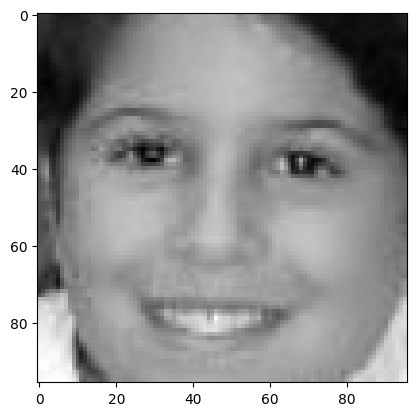

In [ ]:
# getting a random index from array of train images.
random_index=np.random.choice(len(x_train))

# Displaying the image in the gray color mode
plt.imshow(x_train[random_index],cmap='gray')
plt.show()

# Displaying a grid of random images

when displaying the random image with their facial keypoints there are high chances that the keypoints might get displaced. This is so because, we have imputed the null values with the mean. The dataset contain few images of cropped faces and few images with uncropped faces. So, the imputed mean will not be representing the actual key point properly always.

In [ ]:
def display_grid(rows,cols,x_train,y_train):
    """
    Function that generates the grid of random images where number of rows and
    columns needs to be supplied as arguments to the function.
    """
    plt.figure(figsize=(10,10))
    for i in range(rows*cols):
        random_index=np.random.choice(len(x_train))
        plt.subplot(rows,cols,i+1)
        plt.imshow(x_train[random_index], cmap='gray')
        plt.scatter(y_train[random_index,:,0],y_train[random_index,:,1],marker='x',color='red')
    plt.show()

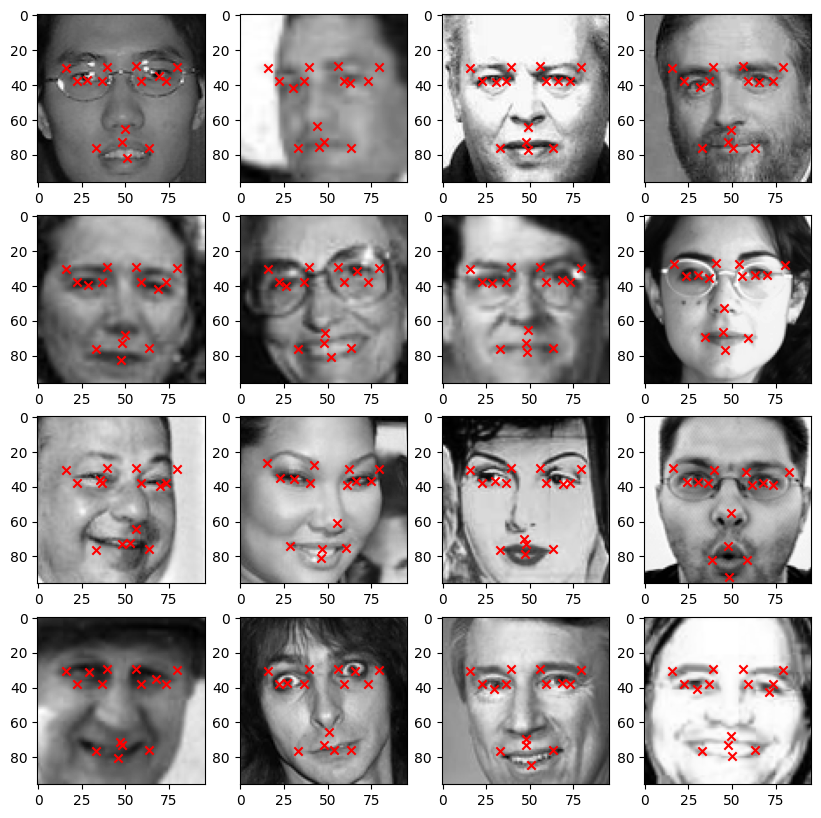

In [ ]:
y_train_reshaped=y_train.values.reshape(y_train.shape[0],15,2)
display_grid(4,4,x_train,y_train_reshaped)

# Image with detailed description for marked keypoint

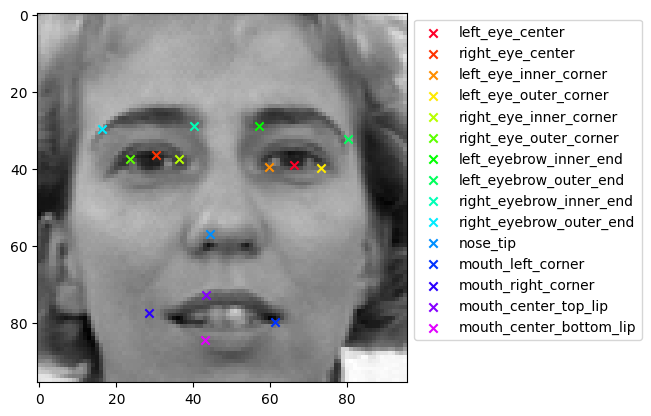

In [ ]:
def plot_features(image,feature_names,features_reshaped):
    """
    Function that marks all the facial keypoints on the image with an explanatory
    legend.
    """
    #image=cv2.flip(image,1)
    NUM_COLORS = 15
    cm = plt.get_cmap('gist_rainbow')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

    ax.imshow(image, cmap='gray')
    for n, name in enumerate(feature_names):
        ax.scatter(features_reshaped[0,n,0],features_reshaped[0,n,1],marker='x',label=name)
    ax.legend(bbox_to_anchor=(1,1))
    plt.show()

plot_features(x_train[np.random.choice(len(x_train))],feature_names,y_train_reshaped)

# Data Modelling

In [ ]:
# Building a CNN model using Sequential API
model = Sequential([
    Conv2D(64, (5, 5), padding='same', use_bias=False, input_shape=(96, 96, 1)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),

    Conv2D(128, (4, 4), padding='same', use_bias=False),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), padding='same', use_bias=False),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),

    Conv2D(512, (2, 2), padding='same', use_bias=False),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),

    Flatten(),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(30)
])

In [ ]:
# printing the summary of the model and parameters.
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 96, 96, 64)        1600      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 96, 96, 64)        0         
                                                                 
 batch_normalization_4 (Bat  (None, 96, 96, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 128)       131072    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 48, 48, 128)      

# Model Training

In [ ]:
# initializing few hyper parameters
epochs = 200
batch_size = 128
validation_split = 0.2

In [ ]:
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])
history=model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split = validation_split)

Epoch 1/200
45/45 [==============================] - 11s 159ms/step - loss: 316.6337 - accuracy: 0.1993 - val_loss: 545.5622 - val_accuracy: 0.5035
Epoch 2/200
45/45 [==============================] - 7s 151ms/step - loss: 104.8708 - accuracy: 0.2680 - val_loss: 251.9924 - val_accuracy: 0.5603
Epoch 3/200
45/45 [==============================] - 7s 154ms/step - loss: 78.3272 - accuracy: 0.2896 - val_loss: 344.5725 - val_accuracy: 0.5738
Epoch 4/200
45/45 [==============================] - 7s 151ms/step - loss: 64.7621 - accuracy: 0.3075 - val_loss: 339.5098 - val_accuracy: 0.5730
Epoch 5/200
45/45 [==============================] - 7s 149ms/step - loss: 64.5707 - accuracy: 0.3396 - val_loss: 335.7131 - val_accuracy: 0.5723
Epoch 6/200
45/45 [==============================] - 7s 154ms/step - loss: 53.9649 - accuracy: 0.3325 - val_loss: 363.0002 - val_accuracy: 0.5738
Epoch 7/200
45/45 [==============================] - 7s 147ms/step - loss: 51.8039 - accuracy: 0.3449 - val_loss: 263.481

In [ ]:
# Saving the weights of the model for re-usability
model.save_weights('weights.h5')

# Model Performance

### Displaying the loss and accuracy plot for both training and Validation

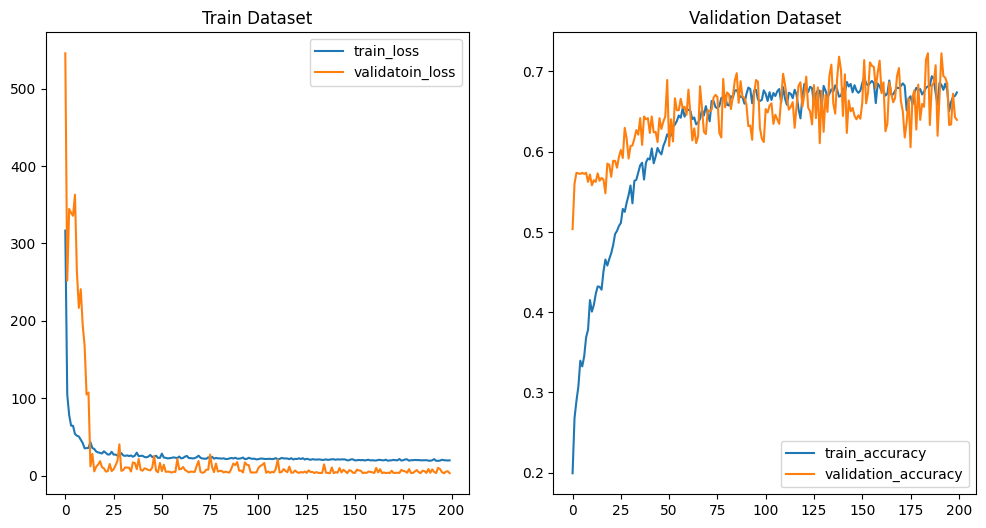

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train Dataset')
plt.plot(history.history['loss'],label='train_loss')
plt.plot(history.history['val_loss'],label='validatoin_loss')
plt.legend()
plt.subplot(1,2,2)
plt.title('Validation Dataset')
plt.plot(history.history['accuracy'],label='train_accuracy')
plt.plot(history.history['val_accuracy'],label='validation_accuracy')
plt.legend()
plt.show()

# Model Validation

In [ ]:
# Getting inferences from the model on the test set.
x_test = return_img_array(test_df)
preds = model.predict(x_test)
print(preds)

56/56 [==============================] - 1s 12ms/step
[[65.8567   36.50361  28.646725 ... 69.73581  46.306854 80.76365 ]
 [67.088974 36.874817 28.36028  ... 73.795525 48.958607 82.2902  ]
 [66.70171  36.75818  30.176193 ... 71.68941  50.26402  78.95382 ]
 ...
 [67.14176  39.239136 30.841652 ... 74.5769   48.314823 77.2136  ]
 [64.588806 38.267746 30.260796 ... 72.53167  47.434765 74.76426 ]
 [66.93691  39.7062   30.233036 ... 75.055046 46.896187 78.46931 ]]


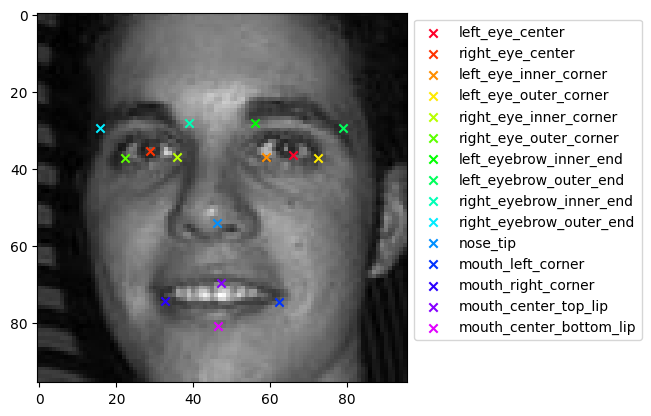

In [ ]:
# looking at the results of the model on test images.
x_test_reshaped=preds.reshape(len(preds),15,2)
plot_features(x_test[np.random.choice(len(x_test))],feature_names,x_test_reshaped)

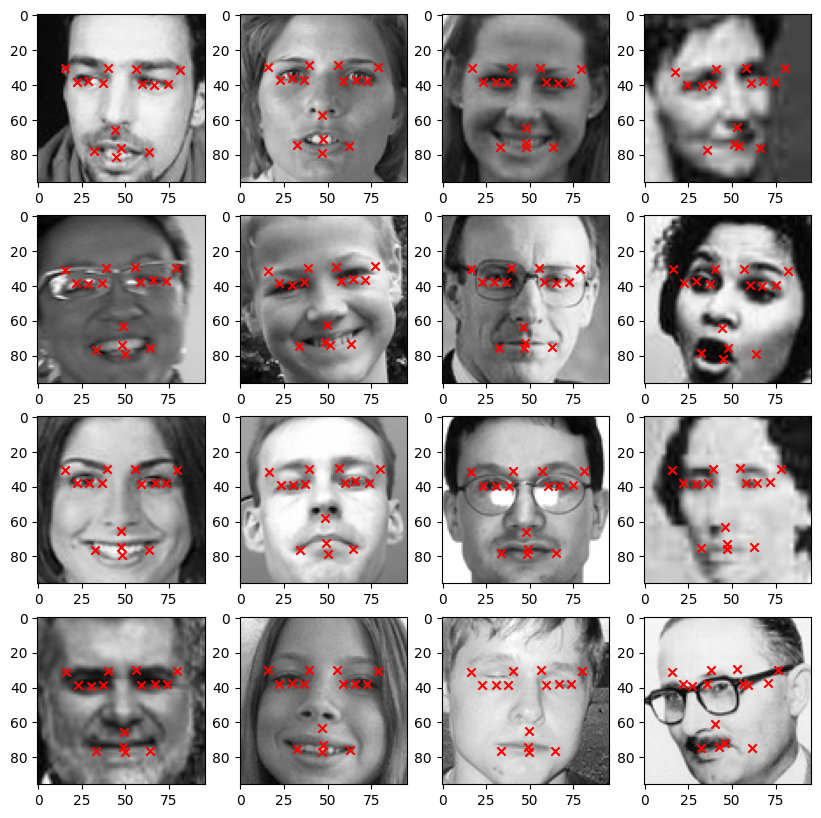

In [ ]:
display_grid(4,4,x_test,x_test_reshaped)

1/1 [==============================] - 0s 19ms/step


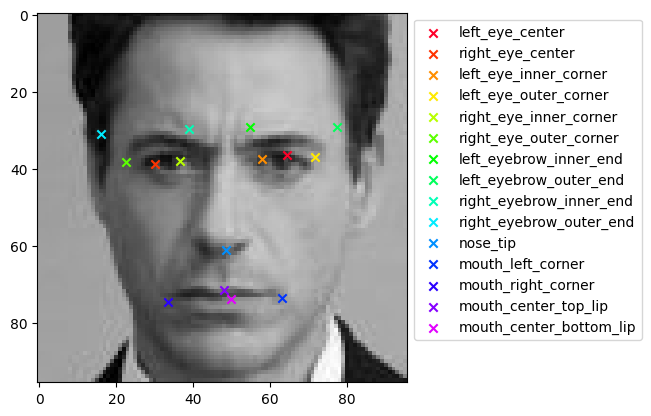

In [ ]:
from skimage.io import imread
from skimage.color import rgb2gray
import numpy as np

# Load and preprocess the image
kev = imread('/content/rdj.jpg')
kev = rgb2gray(kev)
kev = np.expand_dims(kev, axis=0)  # Add batch_size dimension

# Get predictions from the model
kev_pred = model.predict(kev)

# Reshape predictions for plotting
kev_pred_reshaped = kev_pred.reshape(1, 15, 2)

# Display the image with keypoints
plot_features(kev[0], feature_names, kev_pred_reshaped)
